In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

In [2]:
data_path = '../../data/bigram/'

In [76]:
df = pd.read_csv(os.path.join(data_path,'naruto_bigram_jsd.tsv'), sep = '\t')

In [77]:
df = df.drop([0])

In [85]:
np.e

2.718281828459045

In [3]:
sorted(df.JSD.tolist(),reverse=True)

In [30]:
d = dict(zip(df.JSD, df.Kudos))

In [32]:
x = [i for i in sorted(d.keys())]
y = [d[i] for i in sorted(d.keys())]

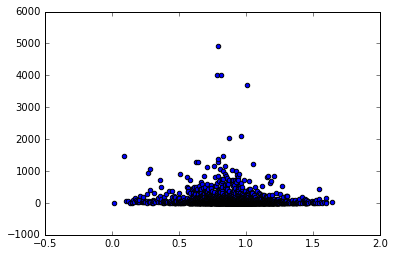

In [33]:
plt.scatter(x, y)

In [4]:
fandom_list = [line.strip() for line in open('../../data/fandom_filtered_list')]

In [5]:
fandom_list

['arthurian_mythology_&_related_fandoms',
 'marvel',
 'attack_on_titan',
 'ms_paint_adventures',
 'bishoujo_senshi_sailor_moon',
 'naruto',
 'buffy_the_vampire_slayer',
 'dcu',
 'one_direction',
 'doctor_who_&_related_fandoms',
 'dragon_age_all_media_types',
 'haikyuu',
 'shakespare_william_works',
 'hamilton_miranda',
 'sherlock_holmes_&_related_fandoms',
 'harry_potter',
 'hetalia_axis_powers',
 'star_wars_all_media_types',
 'homestuck',
 'supernatural',
 'the_avengers_all_media_types',
 'kuroko_no_basuke',
 'the_walking_dead_&_related_fandoms',
 'les_miserables_all_media_types',
 'tolkien_j_r_r_works_&_related_fandoms']

In [6]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

In [7]:
def create_normed_dfs(df):
    df = df.drop([0,1])
    
#     # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a = df_a[['Author', 'Kudos', 'KL', 'Hits']]
#             df_a['Kudos_zscore'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos_zscore != 0]


    # Normalize by using hits/kudos 
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]

#     df['Kudos'] = np.log(df['Kudos'])
#     df['Hits'] = np.log(df['Hits'])
    
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
    # Normalize by log scale
    df = df[df.Kudos != 0]
    df['Kudos'] = np.log(df['Kudos'])
    df = df[df.Hits != 0]
    df['Hits'] = np.log(df['Hits'])

    # filter 0s
#     df = df.fillna(0)

    # turn other fields into z scores
    df['JSD'] = df['JSD'].astype(float)
    df['JSD'] = (df['JSD'] - df['JSD'].mean())/df['JSD'].std(ddof=0)
    df['Kudos/Hits'] = df['Kudos'] - df['Hits']

    #focus on part of the KL range
    df = df[df['JSD'] <= 4]
    df = df[df['JSD'] >= -2]
    return df

In [8]:
def create_dict(fandom_list, field, binsize):
    kj_dict_all = {}
    
    for f in fandom_list:
        df = pd.read_csv(os.path.join(data_path,f+'_bigram_jsd.tsv'), sep = '\t')
        df = create_normed_dfs(df)
        
        # Make bins
        df.JSD = df.JSD.astype(float)
        min_jsd = int(min(df.JSD.tolist())) -1
        max_jsd = int(max(df.JSD.tolist())) +1
        kj_dict = {}
        for i in np.arange(min_jsd, max_jsd, binsize):
            df_s = df[(df.JSD >= i) & (df.JSD < i+binsize)]
#             kk_dict[i] = np.average(df_s.Kudos_zscore.tolist())
            if len(df_s) > 0:
                kj_dict[i] = bootstrap_resample(df_s[field].tolist())
        kj_dict_all[f] = kj_dict
    return kj_dict_all

In [13]:
dic = create_dict(fandom_list, 'Hits', 0.5)

In [14]:
def plot_scatter(fandom_list, dic):
    fig, axs = plt.subplots(5,5, figsize=(30, 20))
    axs = axs.ravel()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'axes.titlesize': 'large'})
    
    for i in range(0, len(fandom_list)):
        x = sorted(dic[fandom_list[i]].keys())
        y = [dic[fandom_list[i]][j][0] for j in x]

#     Make error bars
        lower_error = [dic[fandom_list[i]][j][0]-dic[fandom_list[i]][j][1] for j in x]
        upper_error = [dic[fandom_list[i]][j][2]-dic[fandom_list[i]][j][0] for j in x]
        asymmetric_error = [lower_error, upper_error]

        axs[i].errorbar(x, y, yerr=asymmetric_error,fmt='o')
        axs[i].plot(x, y, 'o-')
        axs[i].set_title(fandom_list[i], fontsize = 20)
        axs[i].set_xlim([min(x) -1, max(x) + 1])
        axs[i].set_ylim([min(y) -0.2, max(y) + 0.2])
        for tick in axs[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axs[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
        
        # ax.set_yscale('log')

    fig.text(0.5, 0.06, 'JSDs', ha='center', va='center', fontsize=25)
    fig.text(0.08, 0.5, 'Log of kudos', ha='center', va='center', rotation='vertical',fontsize=25)
    
    plt.savefig('jsd_kudos_bigram.png', format = 'png')


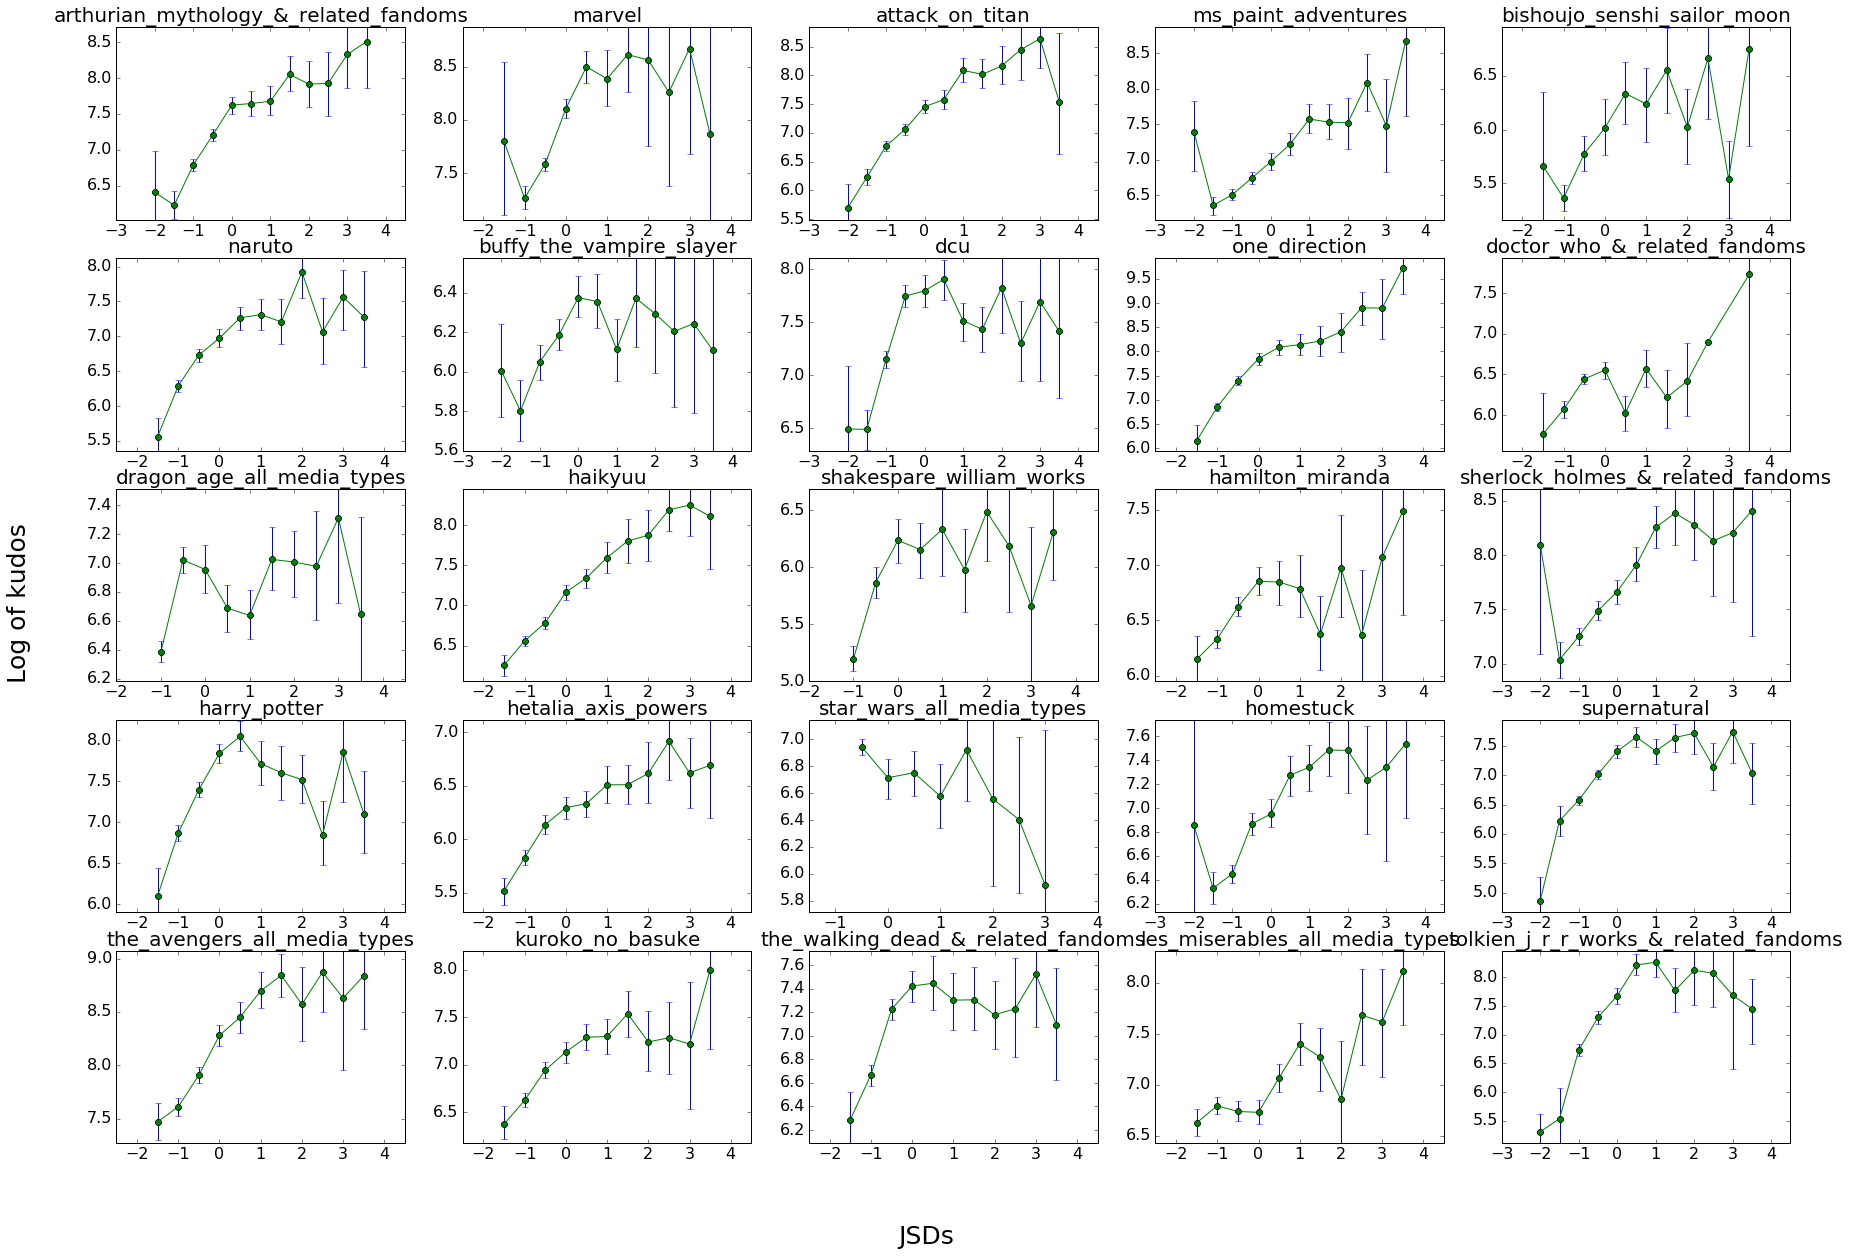

In [15]:
plot_scatter(fandom_list, dic)

In [36]:
# kl_kudos_scatter(fandom_list, 0.1)